In [81]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def party2colour(party):
    if party.startswith('Lab'):
        return 'red'
    if party.startswith('Grn'):
        return 'green'
    if party.startswith('Ind'):
        return 'grey'
    if party.startswith('LDem'):
        return 'yellow'
    if party.startswith('Con'):
        return 'blue'
    if party.startswith('UKIP'):
        return 'purple'

def clean_cols(df):
    df.columns = df.columns.str.lstrip(' ').str.rstrip(' ')
    return df

def get_insolvencies_by_la():
    df = pd.ExcelFile('data/Individual_insolvencies_by_location_2000-17_tables/Total insolvencies 2000_2017.xlsx')
    df = df.parse('Local Authorities')
    df.iloc[1] = df.iloc[1].ffill()
    df.columns = df.iloc[1].fillna('').astype(str) + ' '+ df.iloc[2].fillna('').astype(str)
    df = clean_cols(df)
    return df

def get_election_data():
    df = pd.read_csv('data/LE2018 ward-by-ward results_ London only [Britain Elects] - Totals.csv')
    df.iloc[0,0] = ''
    df.columns = df.iloc[1].fillna('') + ' ' + df.iloc[0].ffill()
    df = clean_cols(df)
    df = df.drop([0,1])
    return df

In [82]:
df_insolv = get_insolvencies_by_la()

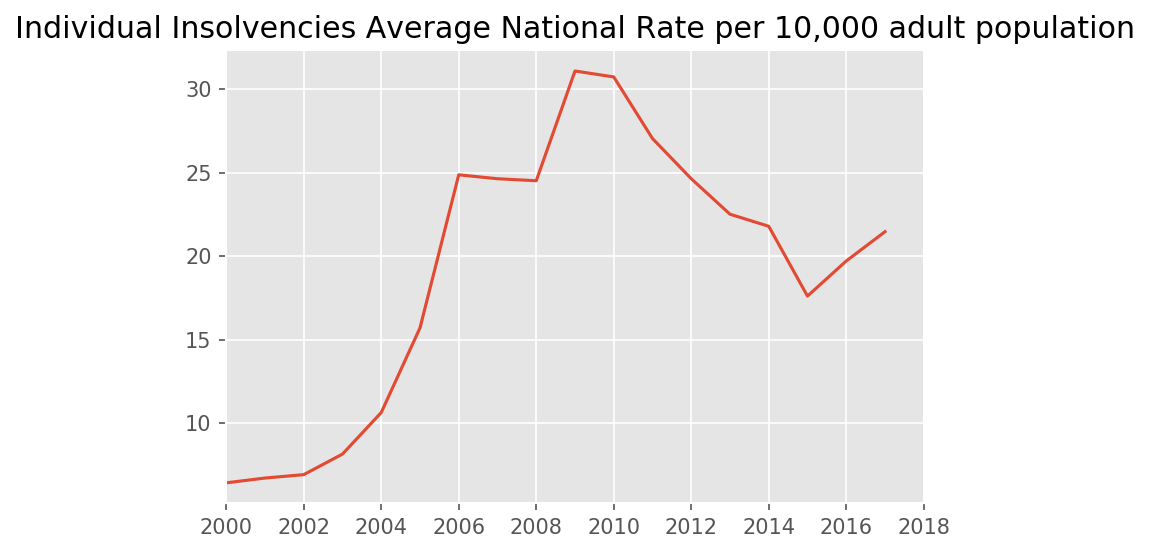

In [85]:
df_insolv_agged = df_insolv.drop([0,1,2])
df_insolv_agged = df_insolv_agged.drop(['Local Authorities'],axis=1)
df_insolv_agged = df_insolv_agged.drop(['Codes'],axis=1)

s = df_insolv_agged.mean()
per_10k = s[s.index.str.contains('Rate per 10,000 adult population')]
per_10k.index = per_10k.index.to_series().apply(lambda x : float(x.split(' ')[0]))

plt.figure(dpi=150)
plt.title('Individual Insolvencies Average National Rate per 10,000 adult population')
per_10k.plot()
plt.xlim(2000,2018)
plt.show()

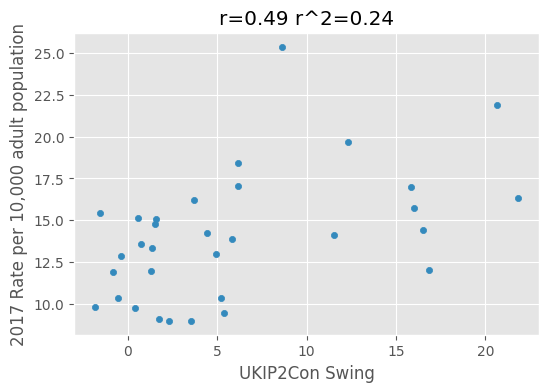

In [202]:
df_elec = get_election_data()
party_a = 'UKIP'
party_b = 'Con'
df_elec[f'{party_a}2{party_b} Swing'] = (df_elec[f'{party_b} PCT +/-'].astype(float) - df_elec[f'{party_a} PCT +/-'].astype(float))/2

x_col = f'{party_a}2{party_b} Swing'
y_col = '2017 Rate per 10,000 adult population'

df_elect_lab = df_elec[['Authority',x_col]].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')
df_elect_lab[x_col] = df_elect_lab[x_col].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[[x_col, y_col]] = df_merged[[x_col, y_col]].astype(float)

fig,ax = plt.subplots(dpi=100)
df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col)

r = df_merged.corr().iloc[0][y_col]
ax.set_title(f'r={round(r,2)} r^2={round(r**2,2)}')
plt.show()

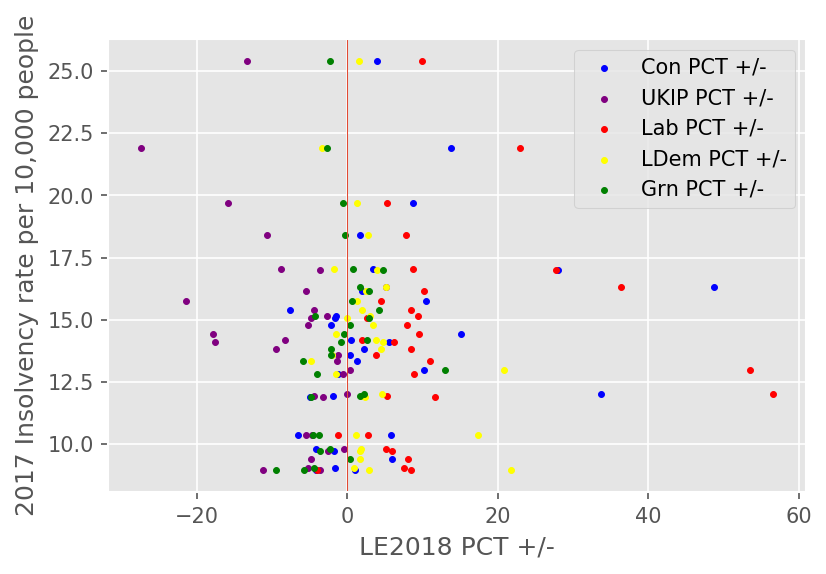

In [191]:
parties = ['Con','UKIP','Lab','LDem','Grn']
x_cols = [f'{party} PCT +/-' for party in parties]

df_elect_lab = df_elec[['Authority'] + x_cols].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')

df_elect_lab[x_cols] = df_elect_lab[x_cols].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[x_cols + [y_col]] = df_merged[x_cols + [y_col]].astype(float)

fig,ax = plt.subplots(dpi=150)
for x_col in x_cols:
    df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col,label=x_col,c=party2colour(x_col),s=8)
ax.set_ylabel('2017 Insolvency rate per 10,000 people')
ax.set_xlabel('LE2018 PCT +/-')
plt.axvline(0,linewidth=0.5)
plt.show()

In [186]:
corr = df_merged.corr()
corr['r'] = corr['2017 Rate per 10,000 adult population']
corr['r^2'] = corr['2017 Rate per 10,000 adult population']**2
corr = corr[['r','r^2']].sort_values(by='r')
corr[corr.r != 1.00]

,r,r^2
UKIP PCT +/-,-0.486734,0.236910
LDem PCT +/-,-0.299321,0.089593
Lab PCT +/-,0.137356,0.018867
Con PCT +/-,0.268314,0.071992
Grn PCT +/-,0.270829,0.073348
